Setup & Imports

In [1]:
# System & Basic
import os
import time
import numpy as np
import pandas as pd
from PIL import Image
import multiprocessing

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# TorchVision
from torchvision import transforms

# Pretrained ViT
import timm

# ML Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Grad-CAM for Explainability
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Utility
from tqdm import tqdm

# Precision, Recall, F1, and plot confusion matrix libs
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Set Random Seed and Device Configuration
# Set random seed for reproducibility
random_seed = 42
# random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    num_gpus = torch.cuda.device_count()
    print(f"Using CUDA (GPU) Available GPUs: {num_gpus}")
    
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    device = torch.device("cpu")
    print("Using CPU (No GPU detected)")

print(f"Running on device: {device}")

/home/yxu33/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using CUDA (GPU) Available GPUs: 4
GPU 0: NVIDIA RTX A5500
GPU 1: NVIDIA RTX A5500
GPU 2: NVIDIA RTX A5500
GPU 3: NVIDIA RTX A5500
Running on device: cuda


Data Loading & Preprocessing

In [2]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['file_name']
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx]['label'])

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Load train.csv
df = pd.read_csv('datasets/train.csv')
df['file_name'] = df['file_name'].apply(lambda x: os.path.join('datasets', x))

# Split data (7:2:1 → train:val:test)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=1/3, stratify=temp_df['label'], random_state=42)

# Create datasets
train_dataset = ImageDataset(train_df, transform=transform)
val_dataset = ImageDataset(val_df, transform=transform)
test_dataset = ImageDataset(test_df, transform=transform)

num_workers = min(8, multiprocessing.cpu_count())

# Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32)
# test_loader = DataLoader(test_dataset, batch_size=32)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader  = DataLoader(val_dataset, batch_size=32, num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=32, num_workers=num_workers, pin_memory=True)

Training & Validation

In [4]:
def train_epoch(model, loader):
    model.train()
    total_loss, correct = 0, 0

    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    total_loss, correct = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return avg_loss, accuracy, precision, recall, f1

In [5]:
def train_model(model, train_loader, val_loader, 
                criterion, optimizer, device, 
                epochs=5, scheduler=None):
    """
    Train the given model and print per-epoch metrics.

    Args:
        model: the neural network
        train_loader: DataLoader for training set
        val_loader: DataLoader for validation set
        criterion: loss function
        optimizer: optimizer for training
        device: torch.device('cuda' or 'cpu')
        epochs: number of training epochs
        scheduler: optional learning rate scheduler
    
    Returns:
        history: dict of lists with keys
         ['train_loss','train_acc','val_loss','val_acc','val_prec','val_rec','val_f1']
    """

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_prec': [], 'val_rec': [], 'val_f1': []
    }

    print("\n=== Training Started ===")
    for epoch in range(epochs):
        print(f"Epoch {epoch+1:02d}:")
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader)
        val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader)

        # save to history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_prec'].append(val_prec)
        history['val_rec'].append(val_rec)
        history['val_f1'].append(val_f1)

        elapsed = time.time() - start_time
        print(f"Epoch {epoch+1:02d} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} || "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
              f"Precision: {val_prec:.4f} | Recall: {val_rec:.4f} | F1: {val_f1:.4f} || "
              f"Time: {elapsed:.2f}s")

        if scheduler:
            scheduler.step(val_loss)

    print("=== Training Finished ===\n")
    return history

Run Training and Plot Metrics

In [6]:
# Prepare model, loss, optimizer

# Vision Transformer Model (Using timm)
# Load a pretrained Vision Transformer and modify for binary classification
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 2)  # Two classes: real vs AI-generated

# Move model to device and wrap with DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = nn.DataParallel(model)

# model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

if isinstance(model, nn.DataParallel):
    used_devices = model.device_ids
    print(f"DataParallel is using device IDs: {used_devices}")
    for i in used_devices:
        print(f" - GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print(f"Model is using single device: {device} ({torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'})")

# loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

Using 4 GPUs with DataParallel
DataParallel is using device IDs: [0, 1, 2, 3]
 - GPU 0: NVIDIA RTX A5500
 - GPU 1: NVIDIA RTX A5500
 - GPU 2: NVIDIA RTX A5500
 - GPU 3: NVIDIA RTX A5500


In [7]:
# Train model

# epochs = 1
# epochs = 5
epochs = 10
# epochs = 20

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=epochs)


=== Training Started ===
Epoch 01:


100%|██████████| 1749/1749 [03:18<00:00,  8.80it/s]


Epoch 01 | Train Loss: 0.0258 | Train Acc: 0.9896 || Val Loss: 0.0179 | Val Acc: 0.9956 | Precision: 0.9925 | Recall: 0.9987 | F1: 0.9956 || Time: 219.14s
Epoch 02:


100%|██████████| 1749/1749 [03:16<00:00,  8.89it/s]


Epoch 02 | Train Loss: 0.0095 | Train Acc: 0.9968 || Val Loss: 0.0219 | Val Acc: 0.9922 | Precision: 0.9852 | Recall: 0.9995 | F1: 0.9923 || Time: 217.15s
Epoch 03:


100%|██████████| 1749/1749 [03:17<00:00,  8.83it/s]


Epoch 03 | Train Loss: 0.0050 | Train Acc: 0.9984 || Val Loss: 0.0096 | Val Acc: 0.9966 | Precision: 0.9966 | Recall: 0.9966 | F1: 0.9966 || Time: 218.33s
Epoch 04:


100%|██████████| 1749/1749 [03:17<00:00,  8.87it/s]


Epoch 04 | Train Loss: 0.0057 | Train Acc: 0.9981 || Val Loss: 0.0085 | Val Acc: 0.9976 | Precision: 0.9970 | Recall: 0.9981 | F1: 0.9976 || Time: 217.48s
Epoch 05:


100%|██████████| 1749/1749 [03:17<00:00,  8.87it/s]


Epoch 05 | Train Loss: 0.0057 | Train Acc: 0.9980 || Val Loss: 0.0140 | Val Acc: 0.9952 | Precision: 0.9912 | Recall: 0.9992 | F1: 0.9952 || Time: 217.53s
Epoch 06:


100%|██████████| 1749/1749 [03:16<00:00,  8.88it/s]


Epoch 06 | Train Loss: 0.0031 | Train Acc: 0.9991 || Val Loss: 0.0055 | Val Acc: 0.9984 | Precision: 0.9970 | Recall: 0.9997 | F1: 0.9984 || Time: 217.65s
Epoch 07:


100%|██████████| 1749/1749 [03:16<00:00,  8.89it/s]


Epoch 07 | Train Loss: 0.0039 | Train Acc: 0.9986 || Val Loss: 0.0082 | Val Acc: 0.9974 | Precision: 0.9985 | Recall: 0.9964 | F1: 0.9974 || Time: 217.23s
Epoch 08:


100%|██████████| 1749/1749 [03:16<00:00,  8.89it/s]


Epoch 08 | Train Loss: 0.0025 | Train Acc: 0.9993 || Val Loss: 0.0131 | Val Acc: 0.9968 | Precision: 0.9992 | Recall: 0.9944 | F1: 0.9968 || Time: 217.03s
Epoch 09:


100%|██████████| 1749/1749 [03:17<00:00,  8.88it/s]


Epoch 09 | Train Loss: 0.0028 | Train Acc: 0.9990 || Val Loss: 0.0067 | Val Acc: 0.9987 | Precision: 0.9980 | Recall: 0.9995 | F1: 0.9988 || Time: 217.38s
Epoch 10:


100%|██████████| 1749/1749 [03:16<00:00,  8.89it/s]


Epoch 10 | Train Loss: 0.0029 | Train Acc: 0.9991 || Val Loss: 0.0073 | Val Acc: 0.9984 | Precision: 0.9978 | Recall: 0.9990 | F1: 0.9984 || Time: 217.02s
=== Training Finished ===



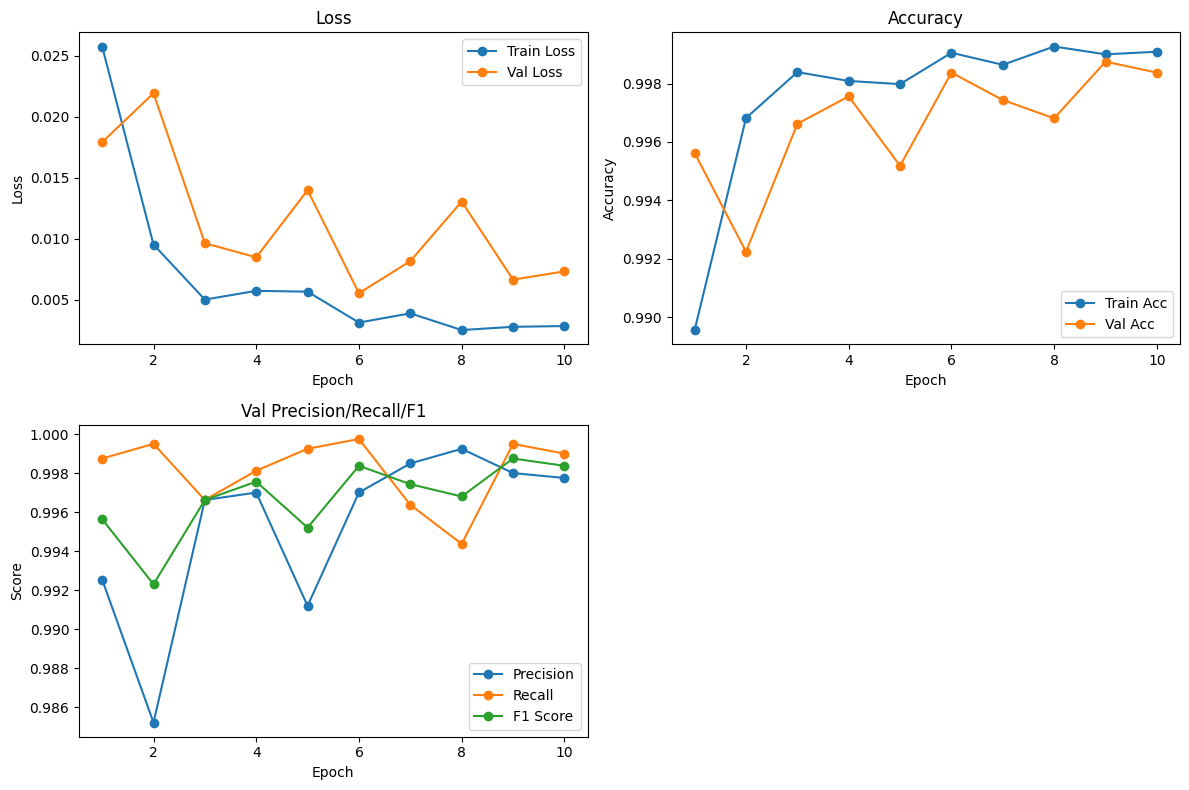

In [8]:
# Plot
epochs = range(1, len(history['train_loss'])+1)

plt.figure(figsize=(12,8))

# Loss
plt.subplot(2,2,1)
plt.plot(epochs, history['train_loss'], 'o-', label='Train Loss')
plt.plot(epochs, history['val_loss'],   'o-', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(2,2,2)
plt.plot(epochs, history['train_acc'], 'o-', label='Train Acc')
plt.plot(epochs, history['val_acc'],   'o-', label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend()

# Precision / Recall / F1
plt.subplot(2,2,3)
plt.plot(epochs, history['val_prec'], 'o-', label='Precision')
plt.plot(epochs, history['val_rec'],  'o-', label='Recall')
plt.plot(epochs, history['val_f1'],   'o-', label='F1 Score')
plt.title('Val Precision/Recall/F1')
plt.xlabel('Epoch'); plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

Testing & Evaluation

=== Classification Report ===
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      3998
AI-Generated       1.00      1.00      1.00      3997

    accuracy                           1.00      7995
   macro avg       1.00      1.00      1.00      7995
weighted avg       1.00      1.00      1.00      7995

Precision: 0.9985
Recall:    0.9987
F1 Score:  0.9986


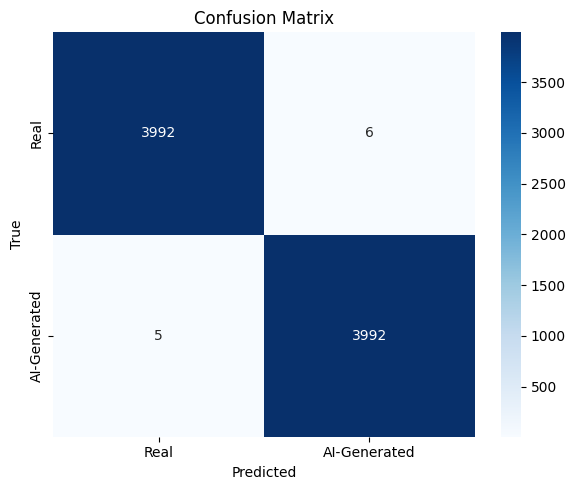

In [9]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print detailed classification report
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=["Real", "AI-Generated"]))

# Print custom metrics
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Real", "AI-Generated"], 
            yticklabels=["Real", "AI-Generated"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Testing & Report

In [10]:
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    print(classification_report(all_labels, all_preds, digits=4))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Explainable AI (Grad-CAM with ViT)

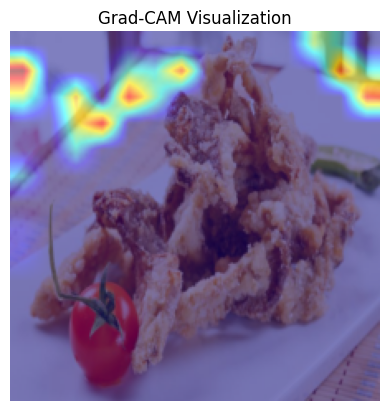

In [11]:
# Define a reshape_transform for Vision Transformer outputs:
# Convert tensor of shape [B, 1 + num_patches, D] into [B, D, H, W].
def reshape_transform(tensor, height=14, width=14):
    # Remove the class token and reshape to [B, H, W, D]
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    # Reorder dimensions to [B, D, H, W]
    return result.permute(0, 3, 1, 2)

# get real base model
base_model = model.module if isinstance(model, nn.DataParallel) else model

# Select the last transformer block's LayerNorm as the target layer
target_layers = [base_model.blocks[-1].norm1]

# Initialize GradCAM with the reshape_transform so it can process ViT features
cam = GradCAM(
    model=model,
    target_layers=target_layers,
    reshape_transform=reshape_transform
)

# Pick one image and its label from the test dataset
image, label = test_dataset[0]
input_tensor = image.unsqueeze(0).to(device)

# Specify the target for which class to visualize
targets = [ClassifierOutputTarget(label)]

# Compute the Grad-CAM heatmap (output shape [B, H, W], take the first batch element)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# Denormalize the image back to [0, 1] range for display
rgb_image = image.permute(1, 2, 0).numpy()
rgb_image = (rgb_image * 0.5 + 0.5).clip(0, 1)

# Superimpose the heatmap onto the original image
visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

# Display the result
import matplotlib.pyplot as plt
plt.imshow(visualization)
plt.title("Grad-CAM Visualization")
plt.axis('off')
plt.show()

Model Saving

In [12]:
os.makedirs('models', exist_ok=True)
model_to_save = model.module if isinstance(model, nn.DataParallel) else model
torch.save(model_to_save.state_dict(), 'models/vit_ai_detection_10.pth')